In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL.ImageCms import Flags
from torch.onnx.symbolic_opset12 import dropout

In [2]:
N = 2
H = 3
T = 20

dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh ** 2)) / N
    norm_list.append(norm)

[np.float64(2.4684068094579303), np.float64(3.335704974161037), np.float64(4.783279375373183), np.float64(6.2795873320876145), np.float64(8.080776465019055), np.float64(10.25116303229294), np.float64(12.9360635066099), np.float64(16.276861327786712), np.float64(20.454829618345983), np.float64(25.688972842084684), np.float64(32.25315718048336), np.float64(40.48895641683869), np.float64(50.824407307019094), np.float64(63.79612654485427), np.float64(80.07737014308985), np.float64(100.51298922051251), np.float64(126.16331847536827), np.float64(158.3592064825883), np.float64(198.77107967611957), np.float64(249.495615421267)]


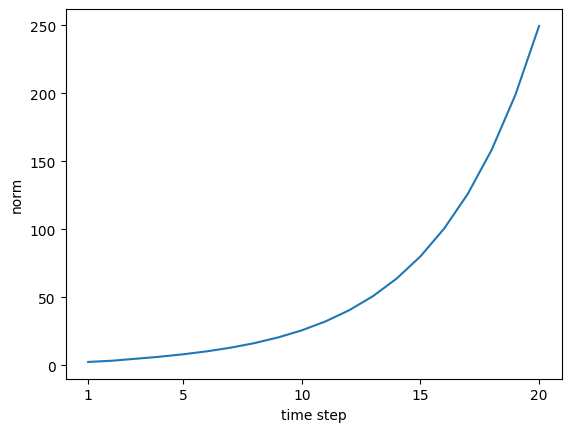

In [3]:
print(norm_list)

plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

[np.float64(1.2342034047289652), np.float64(0.8339262435402592), np.float64(0.5979099219216478), np.float64(0.3924742082554759), np.float64(0.25252426453184545), np.float64(0.16017442237957719), np.float64(0.10106299614538984), np.float64(0.06358148956166684), np.float64(0.039950839098332), np.float64(0.025086887541098325), np.float64(0.015748611904532892), np.float64(0.009884999125204758), np.float64(0.006204151282595104), np.float64(0.003893806551809953), np.float64(0.002443767399386287), np.float64(0.0015337065005571367), np.float64(0.0009625497320203268), np.float64(0.0006040924319556743), np.float64(0.00037912574706291117), np.float64(0.00023793756048323344)]


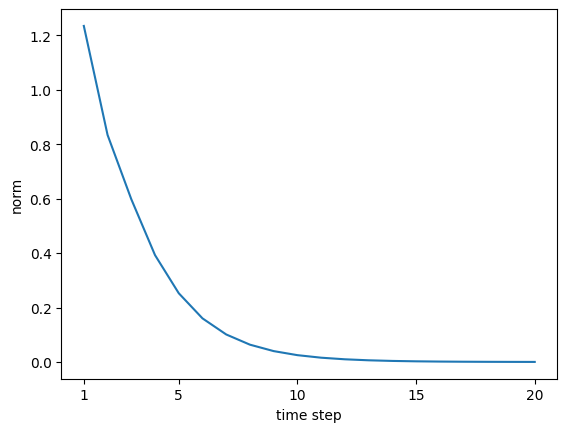

In [4]:
N = 2
H = 3
T = 20

dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh ** 2)) / N
    norm_list.append(norm)
    
print(norm_list)

plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

In [5]:
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

print("Before clipping:")
for i, grad in enumerate(grads):
    print(f"grad {i}: {grad}")

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for i in range(len(grads)):
            grads[i] *= rate
            
clip_grads(grads, max_norm)

print("After clipping:")
for i, grad in enumerate(grads):
    print(f"grad {i}: {grad}")

Before clipping:
grad 0: [[6.49144048 2.78487283 6.76254902]
 [5.90862817 0.23981882 5.58854088]
 [2.59252447 4.15101197 2.83525082]]
grad 1: [[6.93137918 4.40453718 1.56867738]
 [5.44649018 7.80314765 3.06363532]
 [2.21957884 3.87971258 9.3638365 ]]
After clipping:
grad 0: [[1.49503731 0.64138134 1.55747605]
 [1.36081038 0.05523244 1.28709139]
 [0.59708178 0.95601551 0.65298384]]
grad 1: [[1.59635916 1.01440465 0.36128056]
 [1.25437583 1.79713531 0.70558286]
 [0.51118903 0.89353281 2.15657603]]


In [6]:
from common.functions import sigmoid

class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        # Compute gates
        a = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
        
        f = a[:, :H]
        g = a[:, H:2*H]
        i = a[:, 2*H:3*H]
        o = a[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        # Compute cell state and hidden state
        c_next = f * c_prev + i * g
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, o, g, c_next)
        
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev


In [7]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.stateful = stateful        
        self.h = None
        self.c = None
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
            
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')
        
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)            
            hs[:, t, :] = self.h
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, D = dhs.shape
        D = Wh.shape[0]
        
        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0
        
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            self.dh = dh
        return dxs
            
    def set_state(self, h, c=None):
        self.h, self.c = h, c
    
    def reset_state(self):
        self.h, self.c = None, None
        

In [8]:
import sys
sys.path.append('..')
from common.time_layers import *
import pickle

In [11]:
class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            ds = layer.backward(ds)
        return ds
    
    def reset_state(self):
        self.lstm_layer.reset_state()
    
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
    
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

Done
| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 9999.69
| epoch 1 |  iter 21 / 1327 | time 1[s] | perplexity 2840.30
| epoch 1 |  iter 41 / 1327 | time 3[s] | perplexity 1264.05
| epoch 1 |  iter 61 / 1327 | time 5[s] | perplexity 979.14
| epoch 1 |  iter 81 / 1327 | time 6[s] | perplexity 801.28
| epoch 1 |  iter 101 / 1327 | time 8[s] | perplexity 650.77
| epoch 1 |  iter 121 / 1327 | time 9[s] | perplexity 660.18
| epoch 1 |  iter 141 / 1327 | time 11[s] | perplexity 602.83
| epoch 1 |  iter 161 / 1327 | time 13[s] | perplexity 580.77
| epoch 1 |  iter 181 / 1327 | time 15[s] | perplexity 596.36
| epoch 1 |  iter 201 / 1327 | time 16[s] | perplexity 485.97
| epoch 1 |  iter 221 / 1327 | time 18[s] | perplexity 489.50
| epoch 1 |  iter 241 / 1327 | time 19[s] | perplexity 448.49
| epoch 1 |  iter 261 / 1327 | time 21[s] | perplexity 462.54
| epoch 1 |  iter 281 / 1327 | time 23[s] | perplexity 463.36
| epoch 1 |  iter 301 / 1327 | time 24[s] | perplexity 398.78
| epoch 1 |  

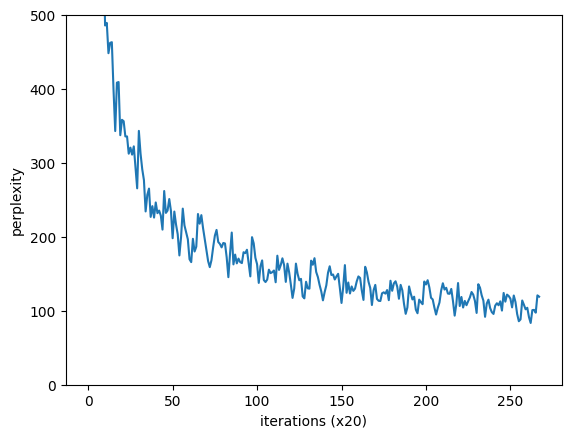

AttributeError: 'Rnnlm' object has no attribute 'lstm_layer'

In [10]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from nndataset import ptb

batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35

lr = 20.0
max_epoch = 4
max_grad = 0.25

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

model.save_params()

In [20]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *
from common.base_model import BaseModel

class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [
            self.layers[2],
            self.layers[4]
        ]
        self.dropout_layers = [
            self.layers[1],
            self.layers[3],
            self.layers[5]
        ]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs, train_flg=False):
        for layer in self.dropout_layers:
            layer.train_flg = train_flg
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

In [21]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from nndataset import ptb

batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25
dropout = 0.5

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)
best_ppl = float('inf')

for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size, time_size=time_size, max_grad=max_grad)
    
    model.reset_state()
    ppl_val = eval_perplexity(model, corpus_val)
    print('val perplexity: ', ppl_val)
    
    if best_ppl > ppl_val:
        best_ppl = ppl_val
        model.save_params('better_rnnlm.pkl')
    else:
        lr /= 4.0
        optimizer.lr = lr
    model.reset_state()
    print('-' * 50)

| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 10000.21
| epoch 1 |  iter 21 / 1327 | time 13[s] | perplexity 3598.00
| epoch 1 |  iter 41 / 1327 | time 25[s] | perplexity 1850.87
| epoch 1 |  iter 61 / 1327 | time 38[s] | perplexity 1286.33
| epoch 1 |  iter 81 / 1327 | time 52[s] | perplexity 1017.38
| epoch 1 |  iter 101 / 1327 | time 65[s] | perplexity 822.02
| epoch 1 |  iter 121 / 1327 | time 77[s] | perplexity 791.66
| epoch 1 |  iter 141 / 1327 | time 90[s] | perplexity 717.94
| epoch 1 |  iter 161 / 1327 | time 103[s] | perplexity 663.38
| epoch 1 |  iter 181 / 1327 | time 115[s] | perplexity 657.43
| epoch 1 |  iter 201 / 1327 | time 128[s] | perplexity 577.20
| epoch 1 |  iter 221 / 1327 | time 141[s] | perplexity 576.47
| epoch 1 |  iter 241 / 1327 | time 153[s] | perplexity 519.14
| epoch 1 |  iter 261 / 1327 | time 166[s] | perplexity 530.42
| epoch 1 |  iter 281 / 1327 | time 180[s] | perplexity 512.95
| epoch 1 |  iter 301 / 1327 | time 193[s] | perplexity 451.07
|

KeyboardInterrupt: 